In [1]:
using Plots
using Statistics
using StatsBase

using LightGraphs
using GraphPlot

In [58]:
function set_node_states(N, qs)
    
    node_type = []

    for i in 1 : N

        state = rand(qs)

        append!(node_type, [(i, state)])

    end

    node_dict = Dict(node_type)
    
    return node_dict
    
end

function init_BA(N, n0, k)
   
    G = barabasi_albert(N, n0, k)

    return G
    
end

function init_ER(N, p)
   
    G = erdos_renyi(N, p)
    
    return G
    
end

function random_imitation(G, node_dic)
    
    #Run for all nodes
    for node in vertices(G)
        
        #Neighbours of the current node
        node_neighbours = neighbors(G, node)
        
        #State of the current node
        node_state = get(node_dic, node, 2)
        
        #Select a random neighbour of the current node
        nn = rand(node_neighbours)
            
        #State of the selected neighbour
        nn_state = get(node_dic, nn, 2)

        #Imitate the selected neighbour
        if node_state != nn_state
            
            merge!(node_dic, Dict(node => nn_state))

        end

    end
    
    return node_dic
    
end

function compute_observables(G, node_dic)
       
    different_links = 0.
    
    #Run for all nodes
    for node in vertices(G)

        #Neighbours of the current node
        node_neighbours = neighbors(G, node)
        
        #State of the current node
        node_state = get(node_dic, node, 2)
        
        for nn in node_neighbours
        
            #State of the selected neighbour
            nn_state = get(node_dic, nn, 2)

            if node_state != nn_state

                different_links += 1

            end
            
        end
        
    end
    
    different_links = different_links / 2 #Each link has been counted twice
    
    return different_links
    
end

function simulation(G, node_dic, t)
    
    density_t = zeros(t)
    
    @inbounds for k in 1 : t
        
        node_dic = random_imitation(G, node_dic)
        
        density_t[k] = compute_observables(G, node_dic)
        
    end
    
    return G, density_t / ne(G)
    
end

function Voter_model_ER(N, p, qs, t)
    
    G = init_ER(N, p)
    
    while ! is_connected(G)
        
        G = init_ER(N, p)
        
    end
    
    node_dic = set_node_states(N, qs)
    
    G, density = simulation(G, node_dic, t)
    
    return G, density
    
end 

function Voter_model_BA(N, n0, k, qs, t)
    
    G = init_BA(N, n0, k)
    
    node_dic = set_node_states(N, qs)
    
    G, density = simulation(G, node_dic, t)
    
    return G, density
    
end 

function compute_avg_ER(N, p, qs, t, times)
    
    taus = zeros(times)
    avg_density = zeros(t)
    
    @inbounds for k in 1 : times
       
        G, density = Voter_model_ER(N, p, qs, t)
        
        avg_density += density
        
        taus[k] = length(density[density .> 0])
         
    end
    
    return avg_density / times, taus
    
end

function compute_avg_BA(N, n0, k, qs, t, times)
    
    taus = zeros(times)
    avg_density = zeros(t)
    
    @inbounds for j in 1 : times
       
        G, density = Voter_model_BA(N, n0, k, qs, t)
        
        avg_density += density
        
        taus[j] = length(density[density .> 0])
         
    end
    
    return avg_density ./ times, taus
    
end

function N_study_ER(Ns, avg_deg, qs, t, times)
    
    f_tau = open("tau_N_ER.txt", "w")
    
    println(f_tau, "#N\t<tau>")
    
    for N in Ns
        
        p = avg_deg / N
        
        density, taus = @time compute_avg_ER(N, p, qs, t, times)
        
        avg_tau = mean(taus)
        
        f = open("results_ER_N_$N.txt", "w")
        
        println(f, "#rho_t")
        
        @inbounds for i in 1 : t
           
            println(f, density[i])
            
        end
        
        close(f)
        
        println(f_tau, N, "\t", avg_tau)
        
    end
    
    close(f_tau)
    
end

function N_study_BA(Ns, n0, k, qs, t, times)
    
    f_tau = open("tau_N_BA.txt", "w")
    
    println(f_tau, "#N\t<tau>")
    
    for N in Ns
        
        density, taus = @time compute_avg_BA(N, n0, k, qs, t, times)
        
        avg_tau = mean(taus)
        
        f = open("results_BA_N_$N.txt", "w")
        
        println(f, "#rho_t")
        
        for i in 1 : t
           
            println(f, density[i])
            
        end
        
        close(f)
        
        println(f_tau, N, "\t", avg_tau)
        
    end
    
    close(f_tau)
    
end

function plateau_study_ER(avg_ks, N, qs, t, times)
    
    plateau_k = zeros(length(avg_ks))
    
    i = 0
    
    @inbounds for avg_k in avg_ks
        
        i += 1
    
        plateau = zeros(t)
        
        p = avg_k / N
        
        @inbounds for k in 1 : times
       
            G, density = Voter_model_ER(N, p, qs, t)

            if all(density != 0)

                plateau += density

            end
            
        end
        
        println(mean(plateau))
        plateau_k[i] = mean(plateau) 
         
    end
    
    return plateau_k
    
end

plateau_study_ER (generic function with 1 method)

# Single realisation 

In [59]:
#General parameters
N = 10^3
qs = [1, 2]

t = 10^4

#BA parameters
n0 = 6
k = 6

times = 1

#ER parameter
p = 8 / N

density, taus = @time compute_avg_ER(N, p, qs, t, times);

  2.157958 seconds (435.62 k allocations: 28.829 MiB, 0.71% gc time)


0.4212664167850317


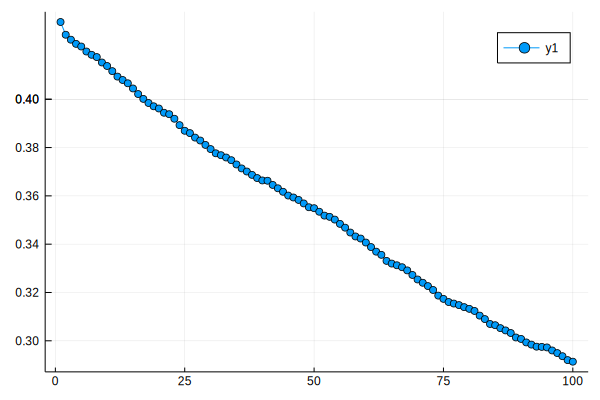

In [56]:
rho = density[density .> 0] 

time = collect(1 : 1 : length(rho))

plot(time, rho, m=:circle)#, xscale=:log10, yscale=:log10)

# N study 

In [13]:
#General parameters
qs = [1, 2]

t = 10^4

#ER parameters
avg_deg = 8

times = 10^0

Ns = [10^3, 2*10^3, 5*10^3]

#N_study_ER(Ns, avg_deg, qs, t, times)

  1.596759 seconds (244.21 k allocations: 20.871 MiB, 0.42% gc time)
